This project is from kaggle competition. https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In this notebook, let us explore the dataset of House Price Prediction. The objective is to predict house sales price (y) based on a number of features. 

Let's start with importing necessary modules. 

In [1]:
import numpy as np
import pandas as pd 
import gc
gc.enable()
import os
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import operator

plotly.tools.set_credentials_file(username='JianweiBao', api_key='U9Ff5soPF5J9mHYtYgse')

import plotly.offline as off
off.init_notebook_mode(connected=True)

print('# File sizes')
for f in os.listdir(r'C:\Users\baoji\Desktop\House Prices Advanced Regression Techniques'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize(r'C:\Users\baoji\Desktop\House Prices Advanced Regression Techniques/' + f) / 1000000, 2)) + 'MB')

C:\Users\baoji\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# File sizes
data_description.txt          0.01MB
sample_submission.csv         0.03MB
sample_submission.csv.gz      0.02MB
test.csv                      0.45MB
test.csv.gz                   0.08MB
train.csv                     0.46MB
train.csv.gz                  0.09MB


In [2]:
train=pd.read_csv(r'C:\Users\baoji\Desktop\House Prices Advanced Regression Techniques/train.csv')
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The distribution of sales price is right skewed, with a median price at 163000 and mean at 180921.

In [5]:
data = [go.Histogram(x=train['SalePrice'])]
layout = go.Layout(title='Distribution of Sales Price')
fig=go.Figure(data=data,layout=layout)
off.iplot(fig)

Let's take a look at the missing values in the data. There are several columns contain over 90% missing values, we can probably exclude those columns in our model. They are "Alley", "PoolQC", "Fense", and "MiscFeature".

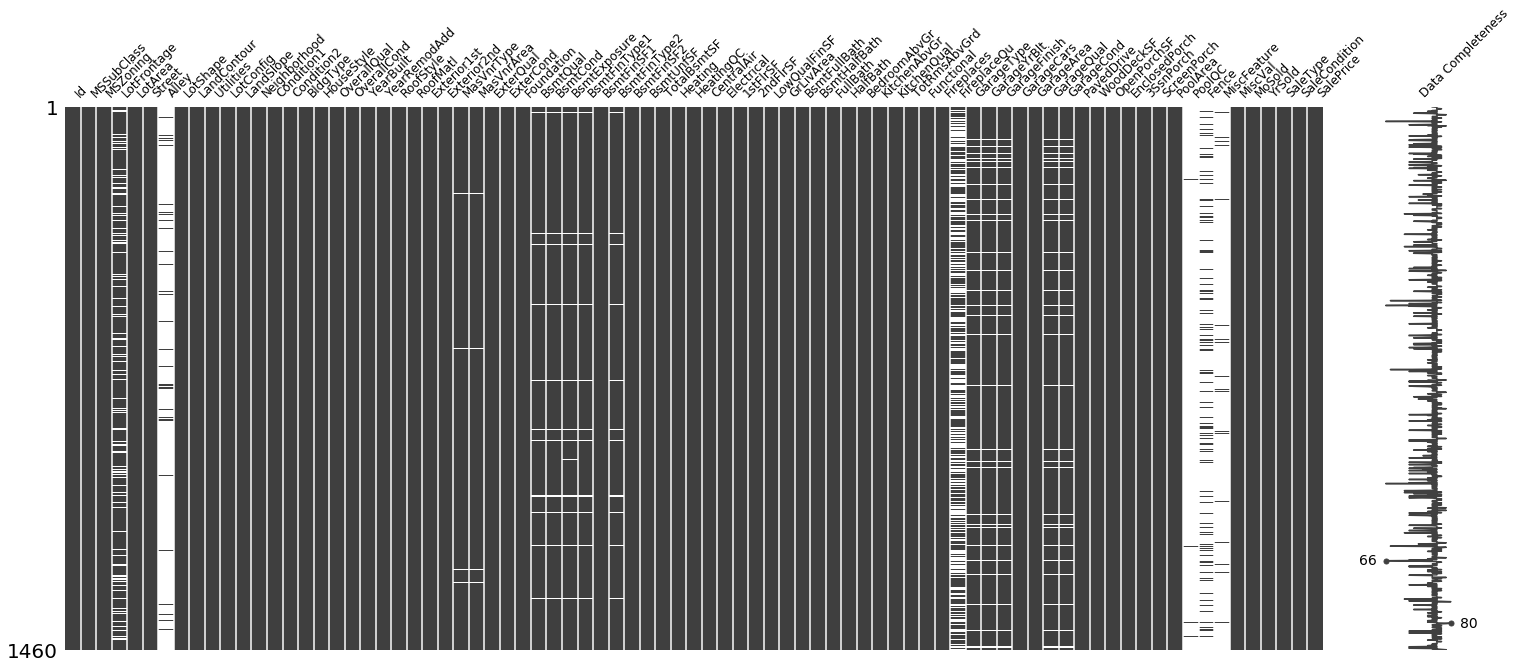

In [6]:
import missingno as msno
%matplotlib inline
msno.matrix(train,labels=True,fontsize=12)

In [7]:
list2=train.columns
list1=[len(train[i].unique()) for i in train.columns]
list1, list2 = zip(*sorted(zip(list1, list2),reverse=True))

data = [go.Bar(
            x=list2,
            y=list1
    )]
layout={
        "title":'Number of Unique Values in Each Variable'
    }
off.iplot({'data':data,'layout':layout})

The graph above shows that most of the variables are categorical, because they have unique values less than 100. A good way to examine the effect of different categories on the sales price is to plot scatter or box plots to see if there is a relationship. Let's check a few of them.

In [8]:
variable='MSSubClass'

data = [dict(
  type = 'scatter',
  x = train[variable],
  y = train['SalePrice'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = train[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Sales Price"},
        "title":"Distribution of Sales Price by " +variable
    }


off.iplot({'data': data, 'layout':layout }, validate=False)

In [9]:
variable='GarageType'

data = [dict(
  type = 'scatter',
  x = train[variable],
  y = train['SalePrice'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = train[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Sales Price"},
        "title":"Distribution of Sales Price by " +variable
    }

off.iplot({'data': data, 'layout':layout}, validate=False)

In [10]:
variable='YearBuilt'

data = [dict(
  type = 'box',
  x = train[variable],
  y = train['SalePrice'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = train[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Sales Price"},
        "title":"Distribution of Sales Price by " +variable
    }

off.iplot({'data': data, 'layout':layout}, validate=False)

In [11]:
variable='Neighborhood'

data = [dict(
  type = 'box',
  x = train[variable],
  y = train['SalePrice'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = train[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Sales Price"},
        "title":"Distribution of Sales Price by " +variable
    }

off.iplot({'data': data, 'layout':layout}, validate=False)

In [12]:
variable='HouseStyle'

data = [dict(
  type = 'box',
  x = train[variable],
  y = train['SalePrice'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = train[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Sales Price"},
        "title":"Distribution of Sales Price by " +variable
    }

off.iplot({'data': data, 'layout':layout}, validate=False)

Correlation Matrix

In [13]:
corr=train.corr()
data = [go.Heatmap( z=corr.values.tolist(),x=corr.columns,y=corr.columns, colorscale='Viridis')]
layout={'title': "Correlation between Variables"}
off.iplot({'data':data,"layout":layout})

In [14]:
covariable=[]
for i in range(len(corr['SalePrice'])):
    if corr['SalePrice'][i]>0.7:
        covariable.append(corr['SalePrice'].index[i])

In [15]:
covariable

['OverallQual', 'GrLivArea', 'SalePrice']

In [16]:
train[covariable].head()

,OverallQual,GrLivArea,SalePrice
0,7,1710,208500
1,6,1262,181500
2,7,1786,223500
3,7,1717,140000
4,8,2198,250000


In [17]:

fig = ff.create_scatterplotmatrix(train[covariable], diag='histogram',
                                  height=800, width=800)
off.iplot(fig)

Let's start setting up models and plot feature importances. Firstly we will need to deal with categorical data and missing values. I will relable the categorical data using LabelEncoder and replace the missing values with mean.

In [18]:
Y=train['SalePrice']
X=train.drop('SalePrice',axis=1)

Let's find out categorical columns that need to relabel for our model.

In [19]:
num_cols = X._get_numeric_data().columns
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [20]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
#relabel categorical columns and replace numeric missing values with mean

for i in X.columns:
    if i not in num_cols:
        X[i] = lb_make.fit_transform(X[i].fillna('anything'))
    else:
        X[i].fillna(X[i].mean(),inplace=True)
        

In [21]:
model = RandomForestRegressor()
model.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
list1, list2 = zip(*sorted(zip(model.feature_importances_, X.columns)))
data = [go.Bar(
            x=list1,
            y=list2,
            orientation = 'h',
            marker=dict(
        color='rgb(67, 67, 67)'))]
layout={
        "title":'Random Forest Feature Importance'
    }
off.iplot({'data':data,'layout':layout})

In [23]:
model2=XGBRegressor()
model2.fit(X,Y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [24]:
dict1=model2.booster().get_score(importance_type='weight')
sorted_dict1 = sorted(dict1.items(), key=operator.itemgetter(1))


In [25]:
list1, list2 = zip(*sorted_dict1)

In [26]:
data = [go.Bar(
            x=list2,
            y=list1,
            orientation = 'h',
            marker=dict(
        color='rgb(252,141,89)'))]
layout={
        "title":'XGB Feature Importance'
    }
off.iplot({'data':data,'layout':layout})
